## Confusion Matrices, Measures of Accuracy, and ROC Curves

Sven Halvorson
2020-04-24

Many statistical and life problems arise when we are trying to make a decision about the truth of the world. We often think in black in white and want to classify things as one of two options. Was this a success or a failure? Are they healthy or ill? Is this milk still good? The truth is often different than our judgement (decision strategy) and a comparison of the two can be represented by a **confusion matrix**. 
  
For whatever reason, certain mathematical concepts have a hard time sticking in my brain. A popular way of plotting a decision strategy, receiver operating characteristic (ROC) curves, is something that I’m embarrassed to say was not natural to me until I manually created them. I think this concept is often poorly explained and there is a lot of confusing terminology. As a result, I wrote this as a reference for myself or anyone else in the event that this knowledge momentarily leaves their brain. I'll also use this as an opportunity to keep my python dreams alive.

### Example Data

We'll be using a dataset of the health of women of Pima Indian descent. Our focus will be on predicting whether or not any individual has diabetes. The head of the datset looks like this:

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Here is the dataset
dm = pd.read_csv('pima-indians-diabetes-database/diabetes.csv')
dm.rename(columns = {'Outcome' : 'diabetes'}, inplace = True)
display(dm.head())
dm.diabetes.value_counts()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


0    500
1    268
Name: diabetes, dtype: int64

There are a number of different demographic and laboratory values for each woman and a binary (yes/no) indicator for whether or not she has diabetes. In this sample 268 (35%) of the 768 subjects have diabetes.
  
### Decision Rule

Our goal is predict whether each Pima woman has diabetes and in order to do that, we need to create a decision rule. This should be some sort of algorithm where, if provided with all of the necessary information, we can give a 'yes' or 'no' diagnosis to a person. To start off, let's just use a very simple rule: If the woman has a glucose level in the top 35% of our sample, we'll guess that they have diabetes. This is cheating a bit as we're using information about the true diabetes status (the proportion of people with diabetes in the sample) but let's just roll with it for now.

Here I'll go through and flag each patient based on whether their in the top 35% or not:

In [55]:
quant35 = dm['Glucose'].quantile([500/768]).to_list()
dm['pred_high_gluc'] = [int(dm['Glucose'][i] > quant35) for i in range(len(dm))]
display(dm[['Glucose', 'diabetes', 'pred_high_gluc']])

,Glucose,diabetes,pred_high_gluc
0,148,1,1
1,85,0,0
2,183,1,1
3,89,0,0
4,137,1,1
...,...,...,...
763,101,0,0
764,122,0,0
765,121,0,0
766,126,1,0




### Confusion Matrix

Now that we have the true state of affairs (diabetes status) as well as a prediction about that status, we can make a **confusion matrix**. This matrix displays the frequencies of every combination of diabetes status and our predictions. The word confusion here refers to that we're not always guessing correctly as displayed in row 766!

Here is the confusion matrix for our simple rule:

In [56]:
pd.crosstab(dm.pred_high_gluc, dm.diabetes, margins=True, margins_name="Total")

diabetes,0,1,Total
pred_high_gluc,,,
0,404,106,510
1,96,162,258
Total,500,268,768


Let's take a moment to interpret this. On the left hand side, we have our two possible predictions and on the top we have the true status (whether or not the patient has diabetes). Our decision rule predicted that 510 people will not have diabetes. Of those 510, 404 were correct and 106 were not. Of the 258 that were predicted to have diabetes, only 162 actually had it.

Each of the four cells has a specific name and these names come in the form of (true/false) (positive/negative). The first word is whether or not the prediction was correct and the second word is the prediction (1 = yes = positive, 0 = no = negative).

Here we have:
* 404 **True negatives**. We predicted no diabetes and the patient was healthy in that regard.
* 106 **False negatives**. Our prediction was no diabetes but they actually have it
* 96 **False positives**. We mistakenly labeled these people as having diabetes
* 162 **True positives**. These people were correctly predicted to have diabetes.


### Measures of success

The next question you might have is, how well did our little rule perform? Did we do a good job guessing using the diabetes status using this cutoff on glucose level alone?

This is where some of the difficulty in memory comes for me. There are *many* different ways to measure the performance of this kind of classification. On top of that, different disciplines have different words to describe the ideas. In one context, we might talk about the *sensitivity* of the decision rule and in another that same thing could be called the *recall*. Here is a summary of the most commonly used ones. The mathematical defintions are all framed in terms of conditional probability.

1. $\textrm{Sensitivity} = P(\textrm{decision = 1}|\textrm{true condition = 1})$

This is the probability that we diagnose a patient as diabetic given that they actually are. The word sensitivity makes me think 'is this test sensitive enough to detect the condition?' Other terms for this are **true positive rate**, **recall**, and **probability of detection**.

2. $\textrm{Specificity} = P(\textrm{decision = 0}|\textrm{true condition = 0})$

The specificity of a decision rule is how frequently we our rule gives non-diagnoses to patients without diabetes. Here I like ot think that a highly specific decision rule will give diagnoses to specifically patients with the disease. This is sometimes called the **selectivity** or **true negative rate**.

3. $\textrm{Positive predictive value} = P(\textrm{true condition = 1}|\textrm{decision = 1})$

A test's positive predictive value (PPV) is how often a positive test result accurately predicts the condition. If you get an undesirable medical test result, you'll be hoping for a low positive predictive rate on test. This is also called the **precision**. There is also the negative predictive value which is the converse of this.

4. $\textrm{Accuracy} = P(\textrm{correct assessment})$

The accuracy of a decision rule is just the number of correctly assigned observations divided by the total number of observations. This is just saying 'how often did we make the correct decision?'

High values for sensitivity, specificity, PPV, and accuracy are qualities we would like to have for our decision rule. The next few terms speak to the ways in which our decision rule can fail.

5. $\textrm{False positive rate} = P(\textrm{decision = 1}|\textrm{true condition = 0})$

Here we're counting up the proportion of non-diabetics that our decision rule labeled as diabetic. This is also known as a **false alarm**. The converse of these are the **false negaitve/miss rate**.

6. $\textrm{False discovery rate} = P(\textrm{true condition = 0}|\textrm{decision = 1})$

Lastly, we have the false discovery rate. We can think of this as being very happy that we made a discovery, the test was positive, but we were wrong. The converse of this is the **false omission rate**

Returning to our confusion matrix:

In [65]:
pd.crosstab(dm.pred_high_gluc, dm.diabetes, margins=True, margins_name="Total")

diabetes,0,1,Total
pred_high_gluc,,,
0,404,106,510
1,96,162,258
Total,500,268,768


We can compute a few of these measures:

1. $\textrm{Sensitivity} = P(\textrm{decision = 1}|\textrm{true condition = 1}) = \frac{162}{268} = 60.4\%$
  
2. $\textrm{Specificity} = P(\textrm{decision = 0}|\textrm{true condition = 0}) = \frac{404}{500} = 80.8\%$
  
3. $\textrm{PPV} = P(\textrm{true condition = 1}|\textrm{decision = 1}) = \frac{162}{258} = 62.3\%$
  
4. $\textrm{False Positive Rate} = P(\textrm{decision = 1}|\textrm{true condition = 0}) = \frac{96}{500} = 19.2\%$

After looking at these statistics,  we shouldn't be that thrilled about our decision rule. Our sensitivity is rather low; when presented with a diabetic woman, we'll only assess her as such 60% of the time. This rule is more specific though; four out of five times we will correctly give a non-diagnosis to a non-diabetic.

So we've established the confusion matrix and a bunch of fancy terms that describe how well the model performed but why do we want to look at it in so many ways? Why isn't the accuracy of the model a good enough measure on it's own?

There are a number of reasons but the most compelling for me is that the consequences of these decisions are not all equal. In some cases, we might want to have a highly sensitive model because if we fail to diagnose people, they may have serious complications. On the other hand, some conditions might be very costly or dangerous to treat so having false positives could be as much of a problem as false negatives. In that case, a highly specific test could be better.

### ROC curves

I implictly mentioned that there is some tension between the different measures of success so let's consider a few different decision rules:
1. Take no information into account and diagnose everyone as being diabetic. This will have a sensitivity of 100% but we will have a sensitivity of zero.
2. Diagnose everyone as non-diabetic. This will give us the converse, a 100% specificity and 0% sensitivity.
3. Diagnose people randomly according to the overall frequency of diabetes. This will give us 35% sensitivity and 65% specificity which is worse than the decision rule we came up with using the glucose level alone.
4. Become an omniscient being and guess correctly every time. We will have 100% sensitivity and specificity.

From these examples, we can see that although there is often *some* tension between these measures, it's not a strict tradeoff. There are methods of making decisions that do better than others in every measure. With this in mind, it would be nice to have some sort of summary statistic and method of comparing which factors make for good decision rules that doesn't force us to ingest a table of all these different measurements.

One of the most common methods of assessing the effectiveness of is a **receiver operating characteristic (ROC)** curve. This is a graph that gives a feel for how the sensitivity and specificity of play out. The axes of the graph are the sensitivity and and the false positive rate (1-specificity).

Let's go through the creation of the ROC slowly. I found that trying to look at them by just looking at them to be a bit hard but when you see the process, it becomes much clearer.

The first step is to sort the data according to whatever measurement you will use to make the decisions. This is often a summary measure like the output from a model but in our case we just used the glucose level:

In [108]:
dm_roc = dm.copy().sort_values('Glucose', ascending = False)
dm_roc = dm_roc.reset_index(drop = True)[['Glucose', 'pred_high_gluc', 'diabetes']]
display(dm_roc)

,Glucose,pred_high_gluc,diabetes
0,199,1,1
1,198,1,1
2,197,1,0
3,197,1,1
4,197,1,1
...,...,...,...
763,0,0,0
764,0,0,1
765,0,0,1
766,0,0,0


The top 5 people in terms of glucose level  were all predicted to be diabetic by our rule and four of them actually were. The last 5 all have a glucose of zero which I would have thought would be lethal but let's not worry about the integrity of the data right now. 

The next piece is a bit stranger. What we're going to do is compute the cummulative sensitivity and false positive rate descinding through the data set. We'll consider whatever row we're on to be the cutoff for glucose level for our decision rule. In effect, what we're doing is considering all the possible values that are present in the dataset one by one. In order to do this we need to find the cummulative count of diabetics and non-diabetics:

In [109]:
dm_roc['tp_sum'] = np.where(dm_roc.diabetes == 1, 1, 0).cumsum()
dm_roc['fp_sum'] = np.where(dm_roc.diabetes == 0, 1, 0).cumsum()
display(dm_roc)

,Glucose,pred_high_gluc,diabetes,tp_sum,fp_sum
0,199,1,1,1,0
1,198,1,1,2,0
2,197,1,0,2,1
3,197,1,1,3,1
4,197,1,1,4,1
...,...,...,...,...,...
763,0,0,0,266,498
764,0,0,1,267,498
765,0,0,1,268,498
766,0,0,0,268,499


When we look at the first row, we're saying 'we'll diagnose anyone with a glucose of 199 or greater as diabetic. With this cutoff, we'll correctly diagnose 1 person as diabetic.' The fourth row says 'if we select a glucose of 197 as the cutoff, we will have four true positives and one false positive.' You can see how the sensitivity for these first few rows will be very low as we're hitting only the patients with the highest glucose but the specifity will be very high.

Using this we'll compute the sensitivity and false positive rate at each row:

In [117]:
dm_roc['sensitivity'] = dm_roc.tp_sum / dm_roc.diabetes.sum()
dm_roc['false_pos_rate'] = dm_roc.fp_sum / np.where(dm_roc.diabetes == 1, 0, 1).sum()
display(dm_roc)

,Glucose,pred_high_gluc,diabetes,tp_sum,fp_sum,sensitivity,false_pos_rate
0,199,1,1,1,0,0.003731,0.000
1,198,1,1,2,0,0.007463,0.000
2,197,1,0,2,1,0.007463,0.002
3,197,1,1,3,1,0.011194,0.002
4,197,1,1,4,1,0.014925,0.002
...,...,...,...,...,...,...,...
763,0,0,0,266,498,0.992537,0.996
764,0,0,1,267,498,0.996269,0.996
765,0,0,1,268,498,1.000000,0.996
766,0,0,0,268,499,1.000000,0.998


When we look at the very top of the list, we have basically no false positives. We're being very selective (specific) about which patients are diagnosed but we also did not properly diagnose many of the diabetic patients (low sensitivity). 

These final two columns are what we will use to plot the ROC curve:

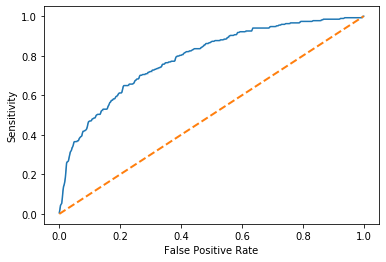

In [136]:
roc = sns.lineplot(x="false_pos_rate", y="sensitivity", data=dm_roc)
roc.set(xlabel='False Positive Rate', ylabel='Sensitivity')
plt.plot([0, 1], [0, 1], linewidth=2, linestyle = '--')
plt.show()

How do we interpret this? It took me a while 

In [126]:
?plt.plot